# Exploratorio datos de clientes para fuga

Buscamos obtener insigths respecto al comportamiento transaccional de los clientes, con el objetivo de definir que es un cliente activo.

Nuestro objetivo final es, usando esta definición, diferenciar entre clientes fugados y activos para así crear un modelo de ML para diferenciar entre estos dos tipos de clientes.

In [1]:
# Importamos librerias a utilizar
import pandas as pd
import numpy as np
from datetime import date

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Conexion a GCP - BigQuery
import pydata_google_auth
from google.cloud import bigquery
SCOPES = [
    'https://www.googleapis.com/auth/cloud-platform',
    'https://www.googleapis.com/auth/drive',
]
credentials = pydata_google_auth.get_user_credentials(
    SCOPES,
    auth_local_webserver=True,
)
client = bigquery.Client(project='gasco-analytics', credentials=credentials)

In [3]:
query_gasconnect = """
SELECT A.*,
      CASE  WHEN A.n_canales = 2 THEN 'ON-OFF'
            WHEN A.n_canales = 1 AND tipo_pedido = 'ONLINE' THEN 'ONLINE'
            WHEN A.n_canales = 1 AND tipo_pedido = 'OFFLINE' THEN 'OFFLINE'
      END AS TIPO_CLIENTE,
      B.predict_estufa,
      B.predict_parrilla,
      B.predict_cocina,
      B.predict_calefont
FROM(
      SELECT EXTRACT(YEAR FROM createdat) AS YEAR,
             CAST(TELEFONO AS INT64) AS TELEFONO,
             SUM(IND_TA) AS PEDIDOS_TA,
             SUM(KILOS_TA) AS KILOS_TA,
             COUNT(DISTINCT createdAT) AS TOTAL_PEDIDOS,
             SUM(total_kilos_pedido) AS TOTAL_KILOS,
             COUNT(DISTINCT MONTH) AS MESES_COMPRA,
             MIN(EXTRACT(DATE FROM createdAt)) AS FECHA_PRIMER_PEDIDO,
             MAX(EXTRACT(DATE FROM createdAt)) AS FECHA_ULTIMO_PEDIDO,
             AVG(dias_compra) AS frec_compra_promedio, 
             stddev(dias_compra) AS desv_frec_compra,
             COUNT(DISTINCT TIPO_PEDIDO_BIEN) AS n_canales, 
             MAX(TIPO_PEDIDO_BIEN) AS tipo_pedido 
      FROM(
            SELECT *, 
                  DATE_DIFF(EXTRACT(DATE FROM createdat),LAG(EXTRACT(DATE FROM createdat)) OVER(PARTITION BY Telefono ORDER BY EXTRACT(DATE FROM createdat)), DAY) AS dias_compra 
            FROM(
                  SELECT *,
                        EXTRACT(YEAR FROM createdAt) AS YEAR,
                        EXTRACT(MONTH FROM createdAt) as MONTH,
                        CASE WHEN mes in (5,6,7,8,9) THEN 1 ELSE 0 END AS IND_TA,
                        CASE WHEN mes in (5,6,7,8,9) THEN total_kilos_pedido ELSE 0 END AS KILOS_TA,
                        CASE WHEN tipo_pedido_bien = 'OFFLINE' THEN customerNoIfOffline
                              WHEN tipo_pedido_bien = 'ONLINE' THEN mobile
                              ELSE mobile END AS Telefono,
                        CASE WHEN status = 'COMPLETED' THEN 'COMPLETADO' ELSE 'NO COMPLETADO' END AS ESTADO_PEDIDO, 
                  FROM `gasco-analytics.gasco.pedidos_gasconnect_todos_javier`
                  WHERE CAST(createdAt as DATE) >= '2019-01-01' --SELECCIONA LOS PEDIDOS DE UN AÑO MOVIL
                  AND isAnulled IS NULL     --PEDIDO NO ANULADO
                  --AND mobile IS NOT NULL    --TELEFONO NO NULO
                  AND TIPO_PEDIDO_BIEN IN ('OFFLINE', 'ONLINE')
            )
            WHERE ESTADO_PEDIDO = 'COMPLETADO'
      )
      GROUP BY EXTRACT(YEAR FROM createdat), TELEFONO
) AS A   

LEFT JOIN `gasco-analytics.gasco_modelos.20210218_prediccion_modelo_uso_gas` AS B  
ON(A.TELEFONO = B.telefono)
"""

**Actualización de los datos: 2021-04-20**

In [4]:
read_data = True
if read_data:
    df_anual = pd.read_csv('datos\datos_exploratorio_fuga.csv',sep = ';', index_col = 0)
else:
    query_job = client.query(query_gasconnect)  # API request
    #rows = query_job.result()  # Waits for query to finish
    df_anual = query_job.to_dataframe()

    #guardamos como csv los datos
    df_anual.to_csv('datos\datos_exploratorio_fuga.csv',sep = ';')

df_anual.head(5)

C:\Users\fbenavides\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,YEAR,TELEFONO,PEDIDOS_TA,KILOS_TA,TOTAL_PEDIDOS,TOTAL_KILOS,MESES_COMPRA,FECHA_PRIMER_PEDIDO,FECHA_ULTIMO_PEDIDO,frec_compra_promedio,desv_frec_compra,n_canales,tipo_pedido,TIPO_CLIENTE,predict_estufa,predict_parrilla,predict_cocina,predict_calefont
0,2020,229660976.0,3,35.0,5,65.0,5,2020-06-22,2020-12-08,42.250000,9.178780,1,OFFLINE,OFFLINE,1.0,0.0,1.0,1.0
1,2020,988048810.0,15,240.0,16,255.0,6,2020-05-19,2020-10-02,9.066667,4.832430,1,ONLINE,ONLINE,1.0,0.0,0.0,0.0
2,2020,982525155.0,4,71.0,6,112.0,3,2020-04-20,2020-09-01,26.800000,30.244008,1,ONLINE,ONLINE,1.0,0.0,1.0,1.0
3,2020,986855339.0,10,128.0,13,165.0,8,2020-01-21,2020-10-24,23.076923,24.098622,1,ONLINE,ONLINE,0.0,0.0,1.0,1.0
4,2020,993379629.0,6,88.0,7,99.0,5,2020-04-14,2020-08-21,41.428571,53.705546,2,ONLINE,ON-OFF,1.0,0.0,1.0,0.0


In [5]:
#Test de sanidad (El total de pedidos siempre debe ser mayor que los meses con compra)
df_anual[df_anual['TOTAL_PEDIDOS']/df_anual['MESES_COMPRA'] < 1]

,YEAR,TELEFONO,PEDIDOS_TA,KILOS_TA,TOTAL_PEDIDOS,TOTAL_KILOS,MESES_COMPRA,FECHA_PRIMER_PEDIDO,FECHA_ULTIMO_PEDIDO,frec_compra_promedio,desv_frec_compra,n_canales,tipo_pedido,TIPO_CLIENTE,predict_estufa,predict_parrilla,predict_cocina,predict_calefont


In [6]:
df_anual['FECHA_PRIMER_PEDIDO'] = pd.to_datetime(df_anual['FECHA_PRIMER_PEDIDO'])
df_anual['FECHA_ULTIMO_PEDIDO'] = pd.to_datetime(df_anual['FECHA_ULTIMO_PEDIDO'])

df_anual['porcentaje_pedidos_TA'] = df_anual['PEDIDOS_TA']/df_anual['TOTAL_PEDIDOS']
df_anual['recencia'] = (date(2021, 4, 7) - df_anual['FECHA_ULTIMO_PEDIDO'].dt.date).dt.days

df_anual.head(2)

,YEAR,TELEFONO,PEDIDOS_TA,KILOS_TA,TOTAL_PEDIDOS,TOTAL_KILOS,MESES_COMPRA,FECHA_PRIMER_PEDIDO,FECHA_ULTIMO_PEDIDO,frec_compra_promedio,desv_frec_compra,n_canales,tipo_pedido,TIPO_CLIENTE,predict_estufa,predict_parrilla,predict_cocina,predict_calefont,porcentaje_pedidos_TA,recencia
0,2020,229660976.0,3,35.0,5,65.0,5,2020-06-22,2020-12-08,42.250000,9.17878,1,OFFLINE,OFFLINE,1.0,0.0,1.0,1.0,0.6000,120
1,2020,988048810.0,15,240.0,16,255.0,6,2020-05-19,2020-10-02,9.066667,4.83243,1,ONLINE,ONLINE,1.0,0.0,0.0,0.0,0.9375,187


# Conteo y deteccion clientes TA

In [7]:
df_2019 = df_anual[df_anual.YEAR == 2019]
df_2020 = df_anual[df_anual.YEAR == 2020]
df_2021 = df_anual[df_anual.YEAR == 2021]


print('Clientes unicos año 2019:', len(df_2019))
print('Clientes unicos año 2020:', len(df_2020))
print('Clientes unicos año 2021:', len(df_2021))
print('Clientes unicos total Gasconnect:', df_anual.TELEFONO.nunique())

Clientes unicos año 2019: 283434
Clientes unicos año 2020: 610201
Clientes unicos año 2021: 232683
Clientes unicos total Gasconnect: 852159


### Clientes Heavy-User Invierno

In [8]:
clientes_TA_2020 = df_2020[df_2020.porcentaje_pedidos_TA == 1]
clientes_TA_2019 = df_2019[df_2019.porcentaje_pedidos_TA == 1]

print('clientes que compran en TA en 2020:',len(clientes_TA_2020))
print('clientes que compran en TA en 2019:',len(clientes_TA_2019))

clientes_TA_total = clientes_TA_2020.merge(clientes_TA_2019,
                                           how = 'outer',
                                           on = 'TELEFONO',
                                           suffixes=('_2020', '_2019'),
                                           indicator = True)
clientes_TA_total.to_csv('clientes_TA_2019_2020.csv',sep = ';')

clientes que compran en TA en 2020: 241376
clientes que compran en TA en 2019: 108684


In [9]:
exclusivos_TA_2020 = clientes_TA_total[clientes_TA_total._merge == 'left_only']  #Solo en 2020
exclusivos_TA_2019 = clientes_TA_total[clientes_TA_total._merge == 'right_only'] #Solo en 2019
clientes_solo_TA   = clientes_TA_total[clientes_TA_total._merge == 'both']       #Ambos años


print('clientes que compraron en TA solo en 2019:',  len(exclusivos_TA_2019))
print('clientes que compraron en TA solo en 2020:',  len(exclusivos_TA_2020))
print('clientes que compraron en TA en ambos años:', len(clientes_solo_TA))

clientes que compraron en TA solo en 2019: 95590
clientes que compraron en TA solo en 2020: 228282
clientes que compraron en TA en ambos años: 13094


### Distribución clientes por %Pedidos en TA

<AxesSubplot:xlabel='porcentaje_pedidos_TA', ylabel='Probability'>

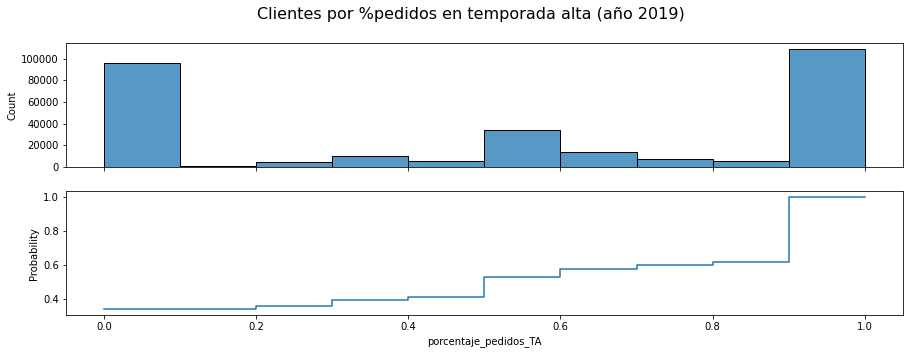

In [10]:
fig, axs = plt.subplots(2, figsize = (15,5), sharex = True)
fig.suptitle('Clientes por %pedidos en temporada alta (año 2019)', fontsize=16)

sns.histplot(ax = axs[0], data = df_2019, x = 'porcentaje_pedidos_TA',binwidth=0.1)
sns.histplot(ax = axs[1], data = df_2019, x = 'porcentaje_pedidos_TA',binwidth=0.1,
             cumulative=True,element="step",fill=False, stat='probability')

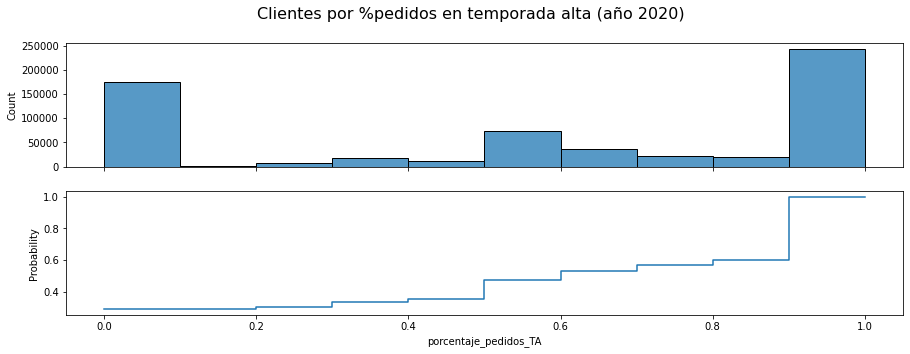

In [11]:
fig, axs = plt.subplots(2, figsize = (15,5), sharex = True)
fig.suptitle('Clientes por %pedidos en temporada alta (año 2020)', fontsize=16)

sns.histplot(ax = axs[0], data = df_2020, x = 'porcentaje_pedidos_TA',binwidth=0.1)
sns.histplot(ax = axs[1], data = df_2020, x = 'porcentaje_pedidos_TA',binwidth=0.1,
             cumulative=True,element="step",fill=False, stat='probability')
fig.savefig('%pedidos_TA.png', bbox_inches='tight')

### Cantidad/porcentaje de clientes con compra en X meses

In [12]:
df_2020.head(2)

,YEAR,TELEFONO,PEDIDOS_TA,KILOS_TA,TOTAL_PEDIDOS,TOTAL_KILOS,MESES_COMPRA,FECHA_PRIMER_PEDIDO,FECHA_ULTIMO_PEDIDO,frec_compra_promedio,desv_frec_compra,n_canales,tipo_pedido,TIPO_CLIENTE,predict_estufa,predict_parrilla,predict_cocina,predict_calefont,porcentaje_pedidos_TA,recencia
0,2020,229660976.0,3,35.0,5,65.0,5,2020-06-22,2020-12-08,42.250000,9.17878,1,OFFLINE,OFFLINE,1.0,0.0,1.0,1.0,0.6000,120
1,2020,988048810.0,15,240.0,16,255.0,6,2020-05-19,2020-10-02,9.066667,4.83243,1,ONLINE,ONLINE,1.0,0.0,0.0,0.0,0.9375,187


In [13]:
n_clientes_2020 = len(df_2020)

conteo_2020 = df_2020[['MESES_COMPRA','TELEFONO']].groupby('MESES_COMPRA').count().reset_index()
conteo_2020['perc_clientes']  = 100*conteo_2020['TELEFONO']/n_clientes_2020
conteo_2020['perc_acumulado'] = conteo_2020['perc_clientes'].cumsum()
conteo_2020

,MESES_COMPRA,TELEFONO,perc_clientes,perc_acumulado
0,1,324844,53.235573,53.235573
1,2,99905,16.372474,69.608047
2,3,58133,9.526861,79.134908
3,4,40397,6.620278,85.755186
4,5,29204,4.785964,90.541150
5,6,21434,3.512613,94.053763
6,7,14235,2.332838,96.386600
7,8,9030,1.479840,97.866441
8,9,6034,0.988854,98.855295
9,10,3580,0.586692,99.441987


<AxesSubplot:xlabel='MESES_COMPRA', ylabel='perc_clientes'>

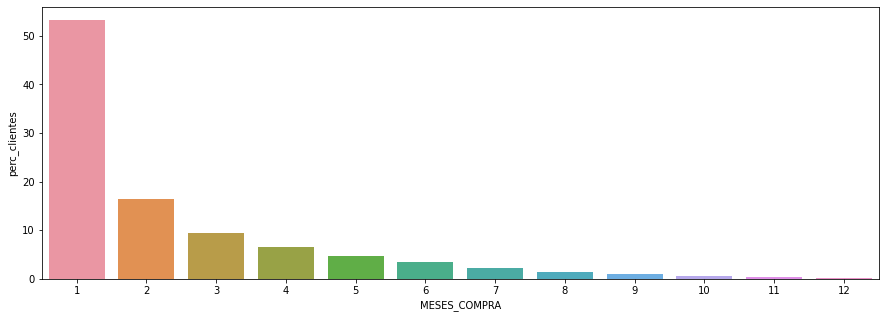

In [14]:
f, ax = plt.subplots(figsize = (15,5))
sns.barplot(data = conteo_2020, x = "MESES_COMPRA", y = "perc_clientes")

### Grafico recencia/ frecuencia/ pedidosTA clientes 2020

In [15]:
df_2020['recencia_2020'] = (date(2020, 12, 31) - df_anual['FECHA_ULTIMO_PEDIDO'].dt.date).dt.days

<ipython-input-15-2bcae77ee0b9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2020['recencia_2020'] = (date(2020, 12, 31) - df_anual['FECHA_ULTIMO_PEDIDO'].dt.date).dt.days


In [16]:
#recencia_2020, MESES_COMPRA,porcentaje_pedidos_TA
a = df_2020[['TELEFONO','MESES_COMPRA','porcentaje_pedidos_TA','recencia_2020']]

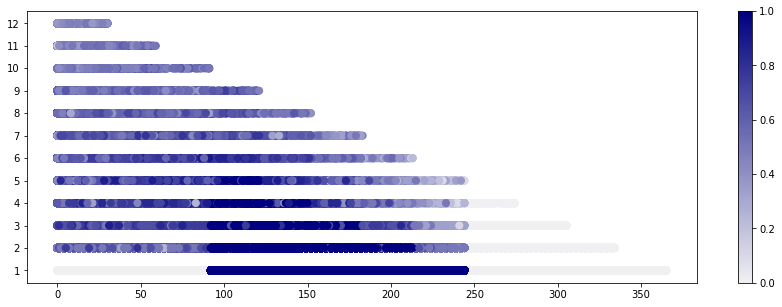

In [17]:
cmap = sns.light_palette("Navy",as_cmap=True)
#cmap = sns.diverging_palette(220, 20, as_cmap=True)


f, ax = plt.subplots(figsize = (15,5))
plt.yticks(np.arange(1, 13, step = 1))
points = ax.scatter(a.recencia_2020, a.MESES_COMPRA, c=a.porcentaje_pedidos_TA, 
                    s=50, cmap=cmap)
f.colorbar(points)

# Analisis por uso de gas

Creamos las siguientes marcas para agrupar por uso de gas:

    a. Exclusivo Estufa.
    b. Exclusivo Parrilla.
    c. Exclusivo Cocina.
    d. Exclusivo Calefont.
    e. Calefont-Cocina Full.
    f. Celefont-Cocina Mixto.
    g. Estufa-Parrilla Full.
    h. Mixto.
    i. Sin clasificar.

In [18]:
condiciones = [
    #Sin Uso de Gas
      (df_2020['predict_estufa'] == 0)   & (df_2020['predict_parrilla'] == 0) &
      (df_2020['predict_calefont'] == 0) & (df_2020['predict_cocina'] == 0),
    #Solo Estufa
      (df_2020['predict_estufa'] == 1)   & (df_2020['predict_parrilla'] == 0) &
      (df_2020['predict_calefont'] == 0) & (df_2020['predict_cocina'] == 0),
    #Solo Parrilla
      (df_2020['predict_estufa'] == 0)   & (df_2020['predict_parrilla'] == 1) &
      (df_2020['predict_calefont'] == 0) & (df_2020['predict_cocina'] == 0),
    #Solo Calefont
      (df_2020['predict_estufa'] == 0)   & (df_2020['predict_parrilla'] == 0) &
      (df_2020['predict_calefont'] == 1) & (df_2020['predict_cocina'] == 0),
     #Solo Cocina
      (df_2020['predict_estufa'] == 0)   & (df_2020['predict_parrilla'] == 0) &
      (df_2020['predict_calefont'] == 0) & (df_2020['predict_cocina'] == 1),
     #Celefont-Cocina Full
      (df_2020['predict_estufa'] == 0)   & (df_2020['predict_parrilla'] == 0) &
      (df_2020['predict_calefont'] == 1) & (df_2020['predict_cocina'] == 1),
     #Celefont-Cocina Mixto
      (df_2020['predict_estufa'] == 1)   & (df_2020['predict_parrilla'] == 0) &
      (df_2020['predict_calefont'] == 1) & (df_2020['predict_cocina'] == 1),
      (df_2020['predict_estufa'] == 0)   & (df_2020['predict_parrilla'] == 1) &
      (df_2020['predict_calefont'] == 1) & (df_2020['predict_cocina'] == 1),
      (df_2020['predict_estufa'] == 1)   & (df_2020['predict_parrilla'] == 1) &
      (df_2020['predict_calefont'] == 1) & (df_2020['predict_cocina'] == 1),
     #Estufa-Parrilla Full
      (df_2020['predict_estufa'] == 1)   & (df_2020['predict_parrilla'] == 1) &
      (df_2020['predict_calefont'] == 0) & (df_2020['predict_cocina'] == 0)
]

valores = ['sin clasificar','solo estufa','solo parrilla','solo calefont','solo cocina',
           'calefont-cocina full','calefont-cocina mixto','calefont-cocina mixto',
           'calefont-cocina mixto','estufa-parrilla full']

df_2020['grupos_uso_gas'] = np.select(condiciones, valores,'mixto')

<ipython-input-18-bed8909d08d7>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2020['grupos_uso_gas'] = np.select(condiciones, valores,'mixto')


In [19]:
conteo_2020_ug = df_2020[['grupos_uso_gas','TELEFONO']].groupby('grupos_uso_gas').count().reset_index()
conteo_2020_ug['perc_clientes'] = 100*conteo_2020_ug['TELEFONO']/n_clientes_2020
conteo_2020_ug

,grupos_uso_gas,TELEFONO,perc_clientes
0,calefont-cocina full,260749,42.731657
1,calefont-cocina mixto,106156,17.396891
2,estufa-parrilla full,5751,0.942476
3,mixto,22357,3.663875
4,sin clasificar,157047,25.736929
5,solo calefont,11824,1.937722
6,solo cocina,8004,1.311699
7,solo estufa,32532,5.331358
8,solo parrilla,5780,0.947229


In [20]:
df_2020_agrupado = df_2020.groupby(['grupos_uso_gas','MESES_COMPRA']).agg(
                        clientes           = ('TELEFONO','count'),
                        kilos_promedio     = ('TOTAL_KILOS','mean'),
                        pedidos_promedio   = ('TOTAL_PEDIDOS','mean'),
                        indice_TA_promedio = ('porcentaje_pedidos_TA','mean') ).reset_index()
df_2020_agrupado.head(2)

,grupos_uso_gas,MESES_COMPRA,clientes,kilos_promedio,pedidos_promedio,indice_TA_promedio
0,calefont-cocina full,1,103189,21.654702,1.075580,0.306118
1,calefont-cocina full,2,43899,45.181143,2.254858,0.406794


In [21]:
clientes_mensuales = df_2020[['MESES_COMPRA','TELEFONO']].groupby('MESES_COMPRA').count()
clientes_mensuales.reset_index(inplace = True)
clientes_mensuales.columns = ['MESES_COMPRA','total_mensual_clientes']

df_2020_agrupado = df_2020_agrupado.merge(clientes_mensuales,
                                          how = 'left',
                                          on = 'MESES_COMPRA')
df_2020_agrupado.head(2)

,grupos_uso_gas,MESES_COMPRA,clientes,kilos_promedio,pedidos_promedio,indice_TA_promedio,total_mensual_clientes
0,calefont-cocina full,1,103189,21.654702,1.075580,0.306118,324844
1,calefont-cocina full,2,43899,45.181143,2.254858,0.406794,99905


In [22]:
df_2020_agrupado['porcentaje_clientes'] = df_2020_agrupado['clientes']/df_2020_agrupado['total_mensual_clientes']
df_2020_agrupado.head()

,grupos_uso_gas,MESES_COMPRA,clientes,kilos_promedio,pedidos_promedio,indice_TA_promedio,total_mensual_clientes,porcentaje_clientes
0,calefont-cocina full,1,103189,21.654702,1.075580,0.306118,324844,0.317657
1,calefont-cocina full,2,43899,45.181143,2.254858,0.406794,99905,0.439407
2,calefont-cocina full,3,29748,69.988436,3.543600,0.485314,58133,0.511723
3,calefont-cocina full,4,23148,95.917228,4.987818,0.537418,40397,0.573013
4,calefont-cocina full,5,18815,124.061600,6.642041,0.565884,29204,0.644261


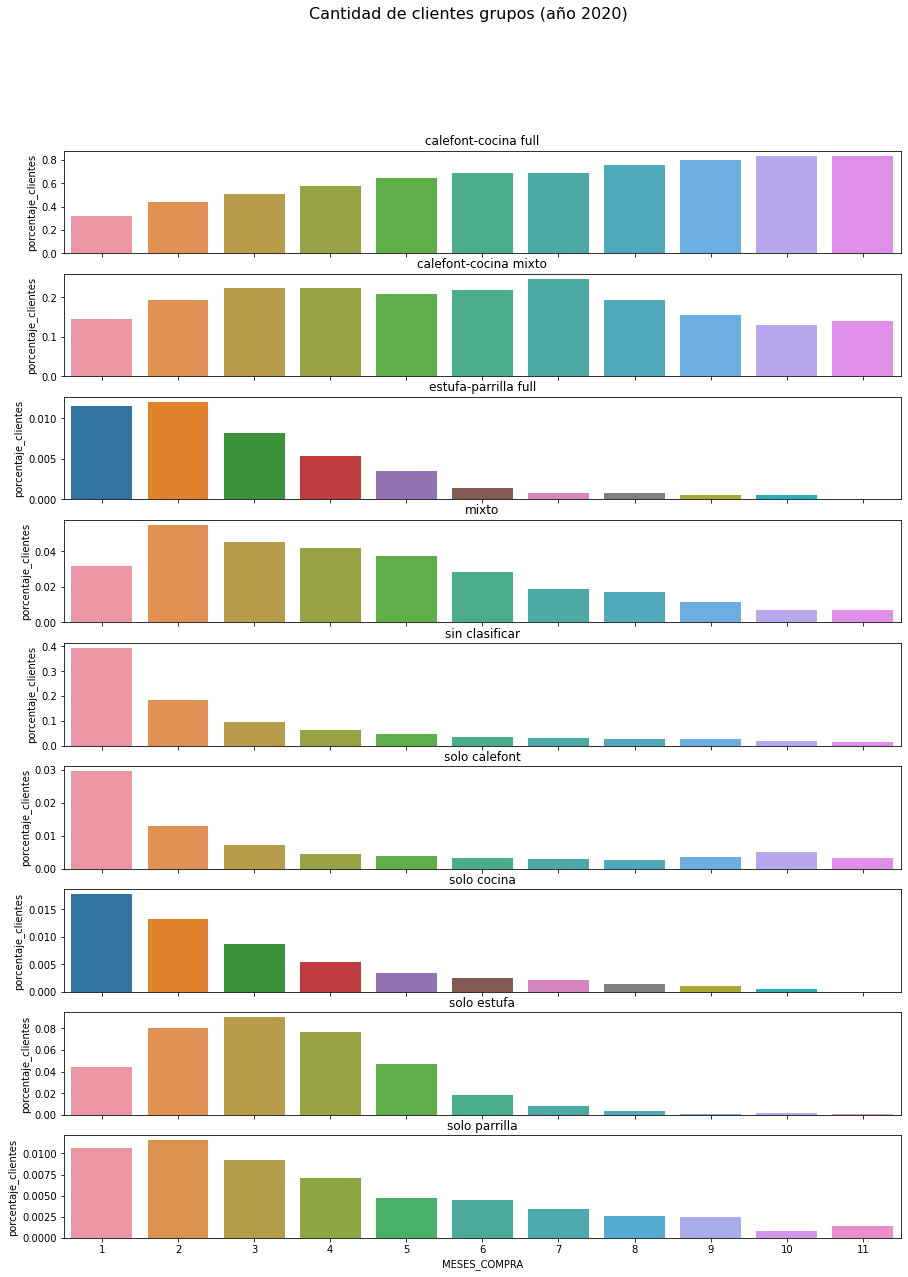

In [23]:
grupos_gas = df_2020_agrupado.grupos_uso_gas.unique()
#len(grupos_gas)

fig, axs = plt.subplots(len(grupos_gas), figsize = (15,20), sharex = True)
fig.suptitle('Cantidad de clientes grupos (año 2020)', fontsize=16)

for i in range(0,len(grupos_gas)):
    #print(i)
    df_plot = df_2020_agrupado[df_2020_agrupado['grupos_uso_gas'] == grupos_gas[i]]
    axs[i].set_title(grupos_gas[i])
    sns.barplot(ax = axs[i], data = df_plot, 
                 x = 'MESES_COMPRA', y = 'porcentaje_clientes')
for ax in axs.flat:
    ax.label_outer()
#sns.histplot(ax = axs[1], data = df_2020, x = 'porcentaje_pedidos_TA',binwidth=0.1,
#             cumulative=True,element="step",fill=False, stat='probability')
#fig.savefig('%pedidos_TA.png', bbox_inches='tight')

<Figure size 1080x72 with 0 Axes>

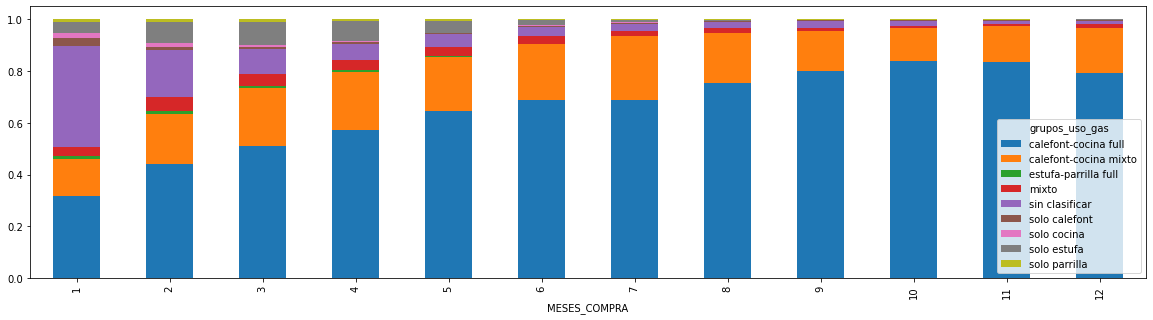

In [24]:
plt.figure(figsize=(15,1))
df_stacked = df_2020_agrupado[['porcentaje_clientes','grupos_uso_gas','MESES_COMPRA']]
#df_stacked.set_index('MESES_COMPRA',inplace = True)


df_stacked = pd.pivot_table(df_stacked,
                            values = 'porcentaje_clientes',
                            index  = 'MESES_COMPRA',
                            columns = 'grupos_uso_gas')
ax = df_stacked.plot.bar(stacked = True,figsize=(20,5))

<AxesSubplot:xlabel='MESES_COMPRA', ylabel='frec_compra_promedio'>

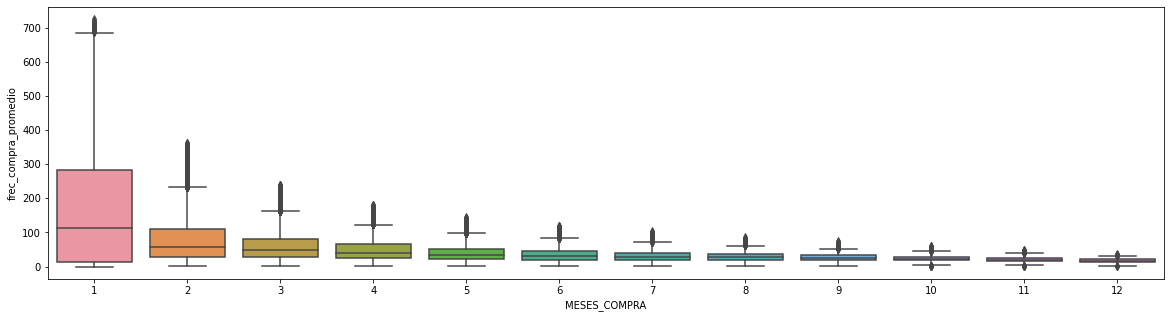

In [25]:
plt.figure(figsize=(20,5))
sns.boxplot(data = df_2020, x = 'MESES_COMPRA', y = 'frec_compra_promedio')

<AxesSubplot:xlabel='MESES_COMPRA', ylabel='recencia_2020'>

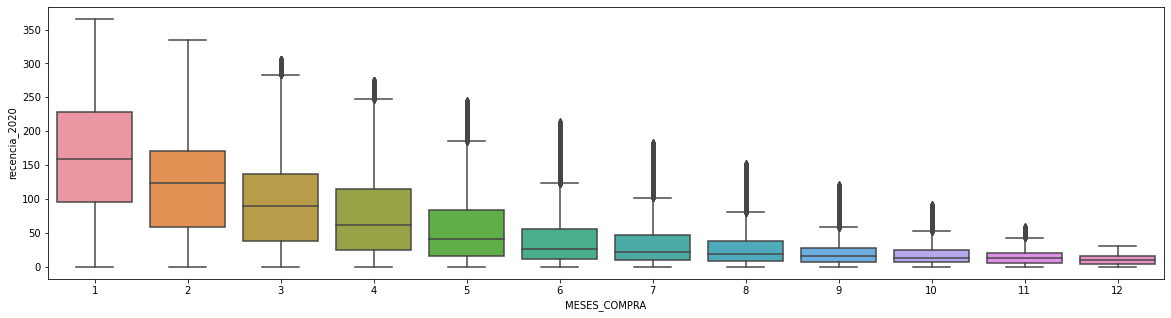

In [26]:
plt.figure(figsize=(20,5))
sns.boxplot(data = df_2020, x = 'MESES_COMPRA', y = 'recencia_2020')

In [27]:
df_quantiles_recencia =  df_2020[['MESES_COMPRA','recencia_2020']].groupby('MESES_COMPRA').agg([('Q1', lambda x: x.quantile(0.25)),
                   ('Q2', lambda x: x.quantile(0.5)),
                   ('Q3', lambda x: x.quantile(0.75))]).reset_index()
df_quantiles_recencia

MESES_COMPRA recencia_2020             
                           Q1   Q2      Q3
0             1            96  159  228.00
1             2            59  123  171.00
2             3            38   90  136.00
3             4            25   61  114.00
4             5            15   40   83.00
5             6            11   26   56.00
6             7             9   21   46.00
7             8             8   18   37.00
8             9             7   15   27.75
9            10             7   13   25.00
10           11             5   12   20.00
11           12             4   10   15.00

In [28]:
df_quantiles_frec =  df_2020[['MESES_COMPRA','frec_compra_promedio']].groupby('MESES_COMPRA').agg([('Q1', lambda x: x.quantile(0.25)),
               ('Q2', lambda x: x.quantile(0.5)),
               ('Q3', lambda x: x.quantile(0.75)),
               ('Q90', lambda x: x.quantile(.90))]
               ).reset_index()
df_quantiles_frec

MESES_COMPRA frec_compra_promedio                                    
                                  Q1          Q2          Q3         Q90
0             1            14.000000  114.000000  283.000000  392.000000
1             2            29.000000   56.000000  111.000000  175.500000
2             3            28.000000   48.000000   82.000000  118.950000
3             4            25.666667   40.666667   64.800000   89.250000
4             5            22.833333   34.666667   52.800000   70.600000
5             6            20.102778   30.571429   45.545455   59.000000
6             7            19.449495   29.133333   40.714286   51.000000
7             8            20.000000   28.250000   36.750000   44.285714
8             9            19.011905   25.559028   32.543706   38.625000
9            10            18.400000   23.411765   28.909091   33.909091
10           11            16.347826   20.647059   25.220455   29.325641
11           12            13.285714   17.000000   20.774510   24.801250

# Analizando formatos por meses de compra

In [29]:
df_formato = pd.read_csv('datos\datos_exploratorio_fuga_formato.csv',sep = ';', index_col = 0)
df_formato.head(2)

C:\Users\fbenavides\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,ANIO,MONTH,TELEFONO,FORMATO,TOTAL_PEDIDOS,FECHA_PRIMER_PEDIDO,FECHA_ULTIMO_PEDIDO,frec_compra_promedio,desv_frec_compra,n_canales,tipo_pedido,TIPO_CLIENTE,predict_estufa,predict_parrilla,predict_cocina,predict_calefont
0,2020,9,989409692.0,p_CN11,1,2020-09-15,2020-09-15,NaN,NaN,1,OFFLINE,OFFLINE,0.0,0.0,1.0,1.0
1,2020,7,994856589.0,p_CN15,1,2020-07-17,2020-07-17,NaN,NaN,1,ONLINE,ONLINE,0.0,0.0,1.0,1.0


In [30]:
df_formato_2 = pd.pivot_table(df_formato,
                              index   = 'TELEFONO',
                              columns = 'FORMATO',
                              values  = 'TOTAL_PEDIDOS',
                              aggfunc =  np.sum,
                              fill_value = 0).reset_index()
df_formato_2.head(2)

FORMATO,TELEFONO,p_CN02,p_CN05,p_CN11,p_CN15,p_CN45
0,2379421.0,0,0,2,0,0
1,8911356.0,0,0,0,1,0


In [31]:
df_2020_formato = df_2020.merge(df_formato_2,
                                how = 'left',
                                on = 'TELEFONO')
df_2020_formato.head(2)

,YEAR,TELEFONO,PEDIDOS_TA,KILOS_TA,TOTAL_PEDIDOS,TOTAL_KILOS,MESES_COMPRA,FECHA_PRIMER_PEDIDO,FECHA_ULTIMO_PEDIDO,frec_compra_promedio,...,predict_calefont,porcentaje_pedidos_TA,recencia,recencia_2020,grupos_uso_gas,p_CN02,p_CN05,p_CN11,p_CN15,p_CN45
0,2020,229660976.0,3,35.0,5,65.0,5,2020-06-22,2020-12-08,42.250000,...,1.0,0.6000,120,23,calefont-cocina mixto,0.0,3.0,0.0,4.0,0.0
1,2020,988048810.0,15,240.0,16,255.0,6,2020-05-19,2020-10-02,9.066667,...,0.0,0.9375,187,90,solo estufa,0.0,17.0,0.0,0.0,0.0


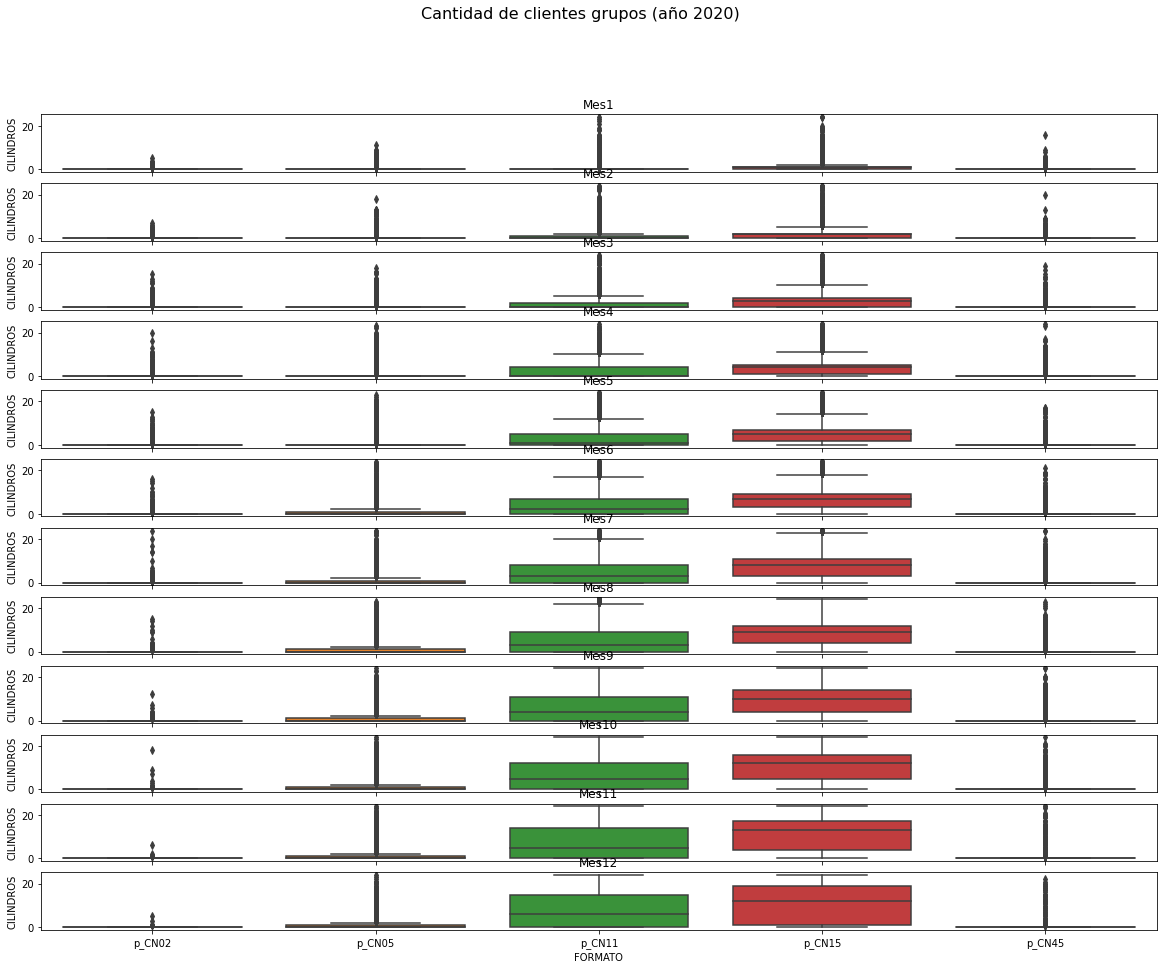

In [32]:
meses = list(range(1,13))
fig, axs = plt.subplots(len(meses), figsize = (20,15), sharex = True)
fig.suptitle('Cantidad de clientes grupos (año 2020)', fontsize=16)

for i in meses:
    df_meses = df_2020_formato[df_2020_formato['MESES_COMPRA'] == i][['TELEFONO','p_CN02','p_CN05','p_CN11','p_CN15','p_CN45']]
    
    df_meses_melt = pd.melt(df_meses,id_vars = 'TELEFONO', 
                            value_vars = ['p_CN02','p_CN05','p_CN11','p_CN15','p_CN45'],
                            var_name  = 'FORMATO',  value_name = 'CILINDROS')
    df_meses_melt = df_meses_melt[df_meses_melt.CILINDROS < 25]
    
    axs[i-1].set_title('Mes' + str(i))
    sns.boxplot(ax = axs[i-1], data = df_meses_melt, x = 'FORMATO', y = 'CILINDROS')

for ax in axs.flat:
    ax.label_outer()

# Analisis recencia hasta actualizadad

In [33]:
df_anual.head()

,YEAR,TELEFONO,PEDIDOS_TA,KILOS_TA,TOTAL_PEDIDOS,TOTAL_KILOS,MESES_COMPRA,FECHA_PRIMER_PEDIDO,FECHA_ULTIMO_PEDIDO,frec_compra_promedio,desv_frec_compra,n_canales,tipo_pedido,TIPO_CLIENTE,predict_estufa,predict_parrilla,predict_cocina,predict_calefont,porcentaje_pedidos_TA,recencia
0,2020,229660976.0,3,35.0,5,65.0,5,2020-06-22,2020-12-08,42.250000,9.178780,1,OFFLINE,OFFLINE,1.0,0.0,1.0,1.0,0.600000,120
1,2020,988048810.0,15,240.0,16,255.0,6,2020-05-19,2020-10-02,9.066667,4.832430,1,ONLINE,ONLINE,1.0,0.0,0.0,0.0,0.937500,187
2,2020,982525155.0,4,71.0,6,112.0,3,2020-04-20,2020-09-01,26.800000,30.244008,1,ONLINE,ONLINE,1.0,0.0,1.0,1.0,0.666667,218
3,2020,986855339.0,10,128.0,13,165.0,8,2020-01-21,2020-10-24,23.076923,24.098622,1,ONLINE,ONLINE,0.0,0.0,1.0,1.0,0.769231,165
4,2020,993379629.0,6,88.0,7,99.0,5,2020-04-14,2020-08-21,41.428571,53.705546,2,ONLINE,ON-OFF,1.0,0.0,1.0,0.0,0.857143,229


In [34]:
#df_recencia = df_recencia.sort_values(by='YEAR', ascending=False).groupby(level=0).first().reset_index()
df_anual.sort_values(by = 'TELEFONO',ascending = True, inplace = True)
cumsum = df_anual[['TELEFONO','MESES_COMPRA']].groupby(['TELEFONO']).cumsum()
df_anual.head()

,YEAR,TELEFONO,PEDIDOS_TA,KILOS_TA,TOTAL_PEDIDOS,TOTAL_KILOS,MESES_COMPRA,FECHA_PRIMER_PEDIDO,FECHA_ULTIMO_PEDIDO,frec_compra_promedio,desv_frec_compra,n_canales,tipo_pedido,TIPO_CLIENTE,predict_estufa,predict_parrilla,predict_cocina,predict_calefont,porcentaje_pedidos_TA,recencia
244857,2020,2379421.0,0,0.0,2,22.0,2,2020-02-18,2020-03-26,37.0,NaN,1,OFFLINE,OFFLINE,0.0,0.0,0.0,0.0,0.0,377
666258,2020,2947459.0,1,5.0,1,5.0,1,2020-08-13,2020-08-13,NaN,NaN,1,OFFLINE,OFFLINE,1.0,0.0,1.0,0.0,1.0,237
837518,2019,2970289.0,1,15.0,1,15.0,1,2019-07-19,2019-07-19,NaN,NaN,1,OFFLINE,OFFLINE,1.0,0.0,1.0,0.0,1.0,628
952604,2019,5733424.0,1,30.0,1,30.0,1,2019-05-19,2019-05-19,NaN,NaN,1,OFFLINE,OFFLINE,0.0,0.0,1.0,1.0,1.0,689
460334,2019,8911356.0,0,0.0,1,15.0,1,2019-12-21,2019-12-21,NaN,NaN,1,OFFLINE,OFFLINE,0.0,0.0,0.0,0.0,0.0,473


In [35]:
df_anual['suma_acum'] = cumsum
b = df_anual[['YEAR','TELEFONO','MESES_COMPRA','suma_acum']].head()

In [36]:
df_anual.MESES_COMPRA.max()

12

In [37]:
df_recencia = df_anual.set_index('TELEFONO')
df_recencia = df_recencia.sort_values(by='YEAR', ascending=False).groupby(level=0).first().reset_index()
df_recencia.head(2)

,TELEFONO,YEAR,PEDIDOS_TA,KILOS_TA,TOTAL_PEDIDOS,TOTAL_KILOS,MESES_COMPRA,FECHA_PRIMER_PEDIDO,FECHA_ULTIMO_PEDIDO,frec_compra_promedio,...,n_canales,tipo_pedido,TIPO_CLIENTE,predict_estufa,predict_parrilla,predict_cocina,predict_calefont,porcentaje_pedidos_TA,recencia,suma_acum
0,2379421.0,2020,0,0.0,2,22.0,2,2020-02-18,2020-03-26,37.0,...,1,OFFLINE,OFFLINE,0.0,0.0,0.0,0.0,0.0,377,2
1,2947459.0,2020,1,5.0,1,5.0,1,2020-08-13,2020-08-13,NaN,...,1,OFFLINE,OFFLINE,1.0,0.0,1.0,0.0,1.0,237,1


#N Clientes excluyendo exclusivos TA: 852159


<AxesSubplot:xlabel='recencia', ylabel='Probability'>

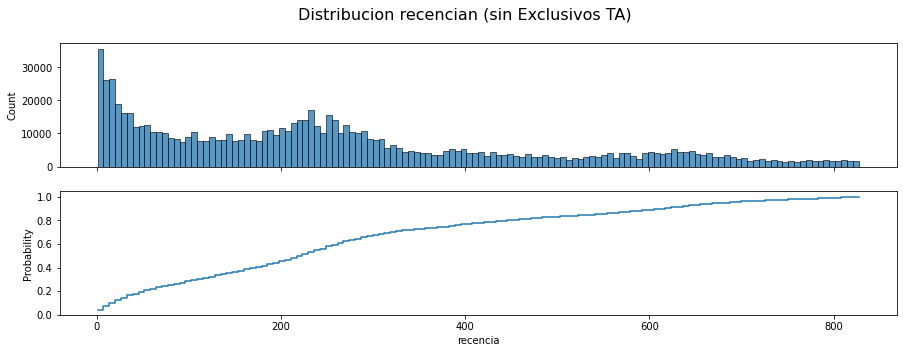

In [38]:
df_filtrado = df_recencia[~df_recencia['TELEFONO'].isin(clientes_solo_TA )]
print('#N Clientes excluyendo exclusivos TA:',len(df_filtrado))

fig, axs = plt.subplots(2, figsize = (15,5), sharex = True)
fig.suptitle('Distribucion recencian (sin Exclusivos TA)', fontsize=16)

sns.histplot(ax = axs[0], data = df_filtrado, x = 'recencia')
sns.histplot(ax = axs[1], data = df_filtrado, x = 'recencia',
             cumulative=True,element="step",fill=False, stat='probability')

In [39]:
df_filtrado_2020 = df_filtrado[df_filtrado.YEAR == 2020]

#N Clientes excluyendo exclusivos TA: 456780


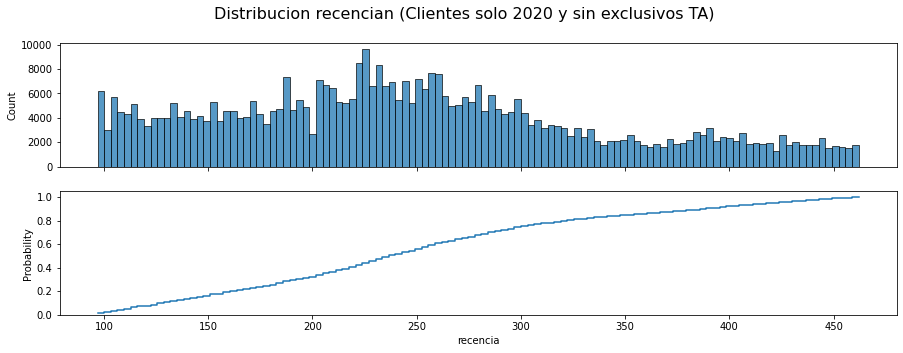

In [40]:
print('#N Clientes excluyendo exclusivos TA:',len(df_filtrado_2020))

fig, axs = plt.subplots(2, figsize = (15,5), sharex = True)
fig.suptitle('Distribucion recencian (Clientes solo 2020 y sin exclusivos TA)', fontsize=16)

sns.histplot(ax = axs[0], data = df_filtrado_2020, x = 'recencia')
sns.histplot(ax = axs[1], data = df_filtrado_2020, x = 'recencia',
             cumulative=True,element="step",fill=False, stat='probability')
fig.savefig('Distr_recencia.png', bbox_inches='tight')

In [41]:
df_filtrado_2020.recencia.quantile(q = [0.25,0.5,0.75,0.9])

0.25    180.0
0.50    239.0
0.75    303.0
0.90    389.0
Name: recencia, dtype: float64

Visualmente pareciera ser que la cantidad de clientes acumulados vs la recencia posee un comportamiento lineal a tramos, en donde los puntos de inflexion se encuentran entre los 200 y 250 días. Vemos que:
    1. El 25% de los clientes tiene una recencia de hasta 136 días.
    2. El 50% de los clientes tiene una recencia de hasta 199 días.
    3. El 75% de los clientes tiene una recencia de hasta 265 días.
    4. El 90% de los clientes tiene una recencia de hasta 353 días (casi un año).

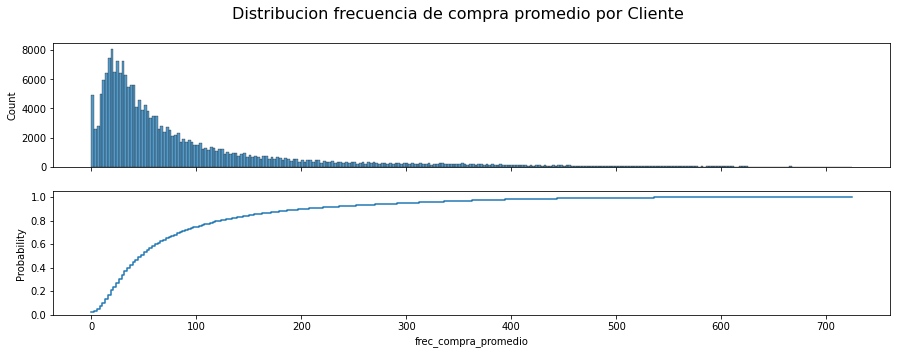

In [42]:
fig, axs = plt.subplots(2, figsize = (15,5), sharex = True)
fig.suptitle('Distribucion frecuencia de compra promedio por Cliente', fontsize=16)

sns.histplot(ax = axs[0], data = df_filtrado_2020, x = 'frec_compra_promedio')
sns.histplot(ax = axs[1], data = df_filtrado_2020, x = 'frec_compra_promedio',
             cumulative=True,element="step",fill=False, stat='probability')

fig.savefig('Distr_frec.png', bbox_inches='tight')

<AxesSubplot:xlabel='frec_compra_promedio'>

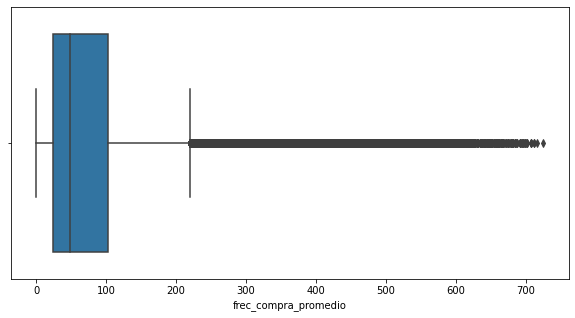

In [43]:
plt.figure(figsize = (10,5))
sns.boxplot(data = df_filtrado_2020, x = 'frec_compra_promedio')

In [44]:
df_filtrado_2020.frec_compra_promedio.quantile(q = [0.75,0.8,0.9])

0.75    102.5
0.80    124.0
0.90    205.0
Name: frec_compra_promedio, dtype: float64

Los clientes con más de una compra suelen comprar, a lo más, cada 200 días. El 75% de los clientes, con más de una compra, realizó su segundo pedido en 3 meses (90 días). Consideramos el valor del ticket promedio como $20.000, calculado usando el valor de todos los pedidos no anulados de Gasconnect.

In [45]:
df_fugados = df_filtrado_2020[df_filtrado_2020['recencia'] > 90]
df_fugados.head(2)

,TELEFONO,YEAR,PEDIDOS_TA,KILOS_TA,TOTAL_PEDIDOS,TOTAL_KILOS,MESES_COMPRA,FECHA_PRIMER_PEDIDO,FECHA_ULTIMO_PEDIDO,frec_compra_promedio,...,n_canales,tipo_pedido,TIPO_CLIENTE,predict_estufa,predict_parrilla,predict_cocina,predict_calefont,porcentaje_pedidos_TA,recencia,suma_acum
0,2379421.0,2020,0,0.0,2,22.0,2,2020-02-18,2020-03-26,37.0,...,1,OFFLINE,OFFLINE,0.0,0.0,0.0,0.0,0.0,377,2
1,2947459.0,2020,1,5.0,1,5.0,1,2020-08-13,2020-08-13,NaN,...,1,OFFLINE,OFFLINE,1.0,0.0,1.0,0.0,1.0,237,1


In [46]:
# Cantidad de clientes considerados "Fugados"
print(len(df_fugados[df_fugados['porcentaje_pedidos_TA'] == 1]))
print(len(df_fugados))

219935
456780


## Estimacion (Gruesa del valor) y resumen:

1. Utilizamos como Benchmark una recencia de 100 días (3.3 meses aprox). Este Benchmark es una estimación gruesa de contrastar la frec de compra para los clientes que tienen más de un medido y la recencia. Para esto se consideran solo a los Clientes que compraron durante el 2020.
2. Se eliminan del analisis clientes que solo tienen pedidos en temporada alta durante el 2019 y 2020, los cuales son catalogados como clientes especificos de dicha temporada, correspondiendo a un total de 13094 clientes.
3. Con lo anterior, con fecha 2021-03-02, hay un total de 412852 clientes que realizaron su último pedido hace más de 100 días, de los cuales 214901 realizaron su ultimo pedido en temporada alta.
4. Si consideramos un Ticket Promedio de **CLP 20.000** (valor obtenido usando todas las transacciones de Gasconnect de 2020 completados y no anulados), un potencial de clientes de 197951, obtenido de restar el total de clientes "Fugados" y los que realizaron su ultima compra en temporada alta, con una conversion del 2%, nos da un valor potencia estimado de **CLP 79.180.400**

# Analisis de reposicion del gas

In [47]:
df_clientes_regulares = df_filtrado_2020[df_filtrado_2020['TOTAL_PEDIDOS'] > 3]
len(df_clientes_regulares)

66422

In [48]:
df_1 = df_clientes_regulares[df_clientes_regulares['frec_compra_promedio'] < df_clientes_regulares['recencia']]
len(df_1)

65913

In [49]:
df_1['benchmark'] = df_1['frec_compra_promedio'] + 2*df_1['desv_frec_compra']
df_2 = df_1[df_1['benchmark'] < df_1['recencia']]
len(df_2)

<ipython-input-49-92b43e353aa9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['benchmark'] = df_1['frec_compra_promedio'] + 2*df_1['desv_frec_compra']


52168

# Testing code